## Section A: PCA & Loadings
**Problem:** **Multicollinearity**. Medical features are often highly correlated (e.g., Hemoglobin & Hematocrit).
**Solution:** PCA (Principal Component Analysis) creates orthogonal (independent) components, addressing **Multicollinearity** by transforming dependent features into independent Principal Components for downstream clustering.

### PCA "Inside the Box" (Loadings)
This plot reveals which biological features drive the variance in PC1 and PC2 by showing the strongest loadings (absolute weights).

## Section B: Attempt 1 - K-Means (The Baseline)
We run K-Means for k=2 to k=10, inspect the **Elbow Curve**, then pick the best k (based on the elbow) and fit K-Means. We also report cluster sizes to check for imbalance/outliers.

C:\Users\amitf\AppData\Local\Temp\ipykernel_15936\2924593532.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loadings.loc[top_pc1, "PC1"], y=top_pc1, ax=axes[0], palette="viridis")
C:\Users\amitf\AppData\Local\Temp\ipykernel_15936\2924593532.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loadings.loc[top_pc2, "PC2"], y=top_pc2, ax=axes[1], palette="magma")


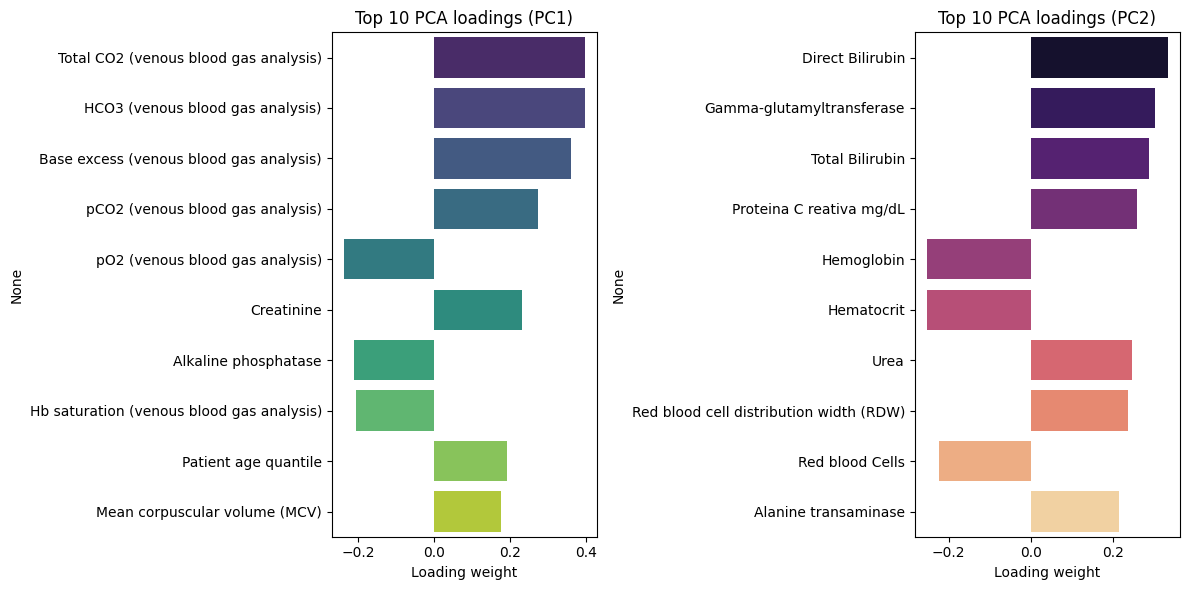

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from pathlib import Path

# Paths
IN_PATH = Path("../data/processed/01_cleaned_data.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load cleaned, already scaled data
df = pd.read_csv(IN_PATH)
if "Patient ID" in df.columns:
    df = df.set_index("Patient ID")

# Targets and features
targets = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]
features = [c for c in df.columns if c not in targets]

X = df[features].values

# PCA (for visualization only)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)

# PCA loadings (top 10 absolute weights for PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10).index
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10).index

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=loadings.loc[top_pc1, "PC1"], y=top_pc1, ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 PCA loadings (PC1)")
axes[0].set_xlabel("Loading weight")
sns.barplot(x=loadings.loc[top_pc2, "PC2"], y=top_pc2, ax=axes[1], palette="magma")
axes[1].set_title("Top 10 PCA loadings (PC2)")
axes[1].set_xlabel("Loading weight")
plt.tight_layout()
loadings_path = FIG_DIR / "pca_loadings_top10.png"
plt.savefig(loadings_path, dpi=200)
plt.show()


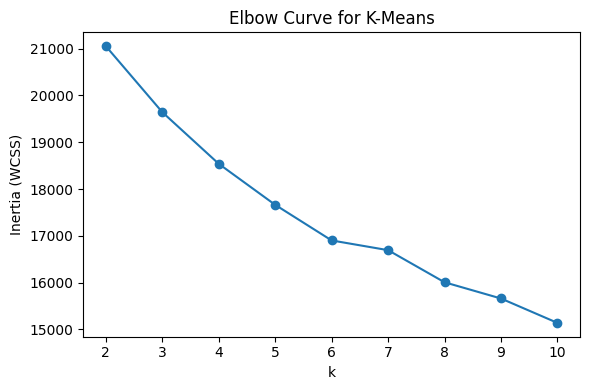

K-Means cluster sizes:
count
0    575
1      1
2     27
Name: count, dtype: int64
K-Means silhouette (k=3): 0.4356


In [7]:
# K-Means baseline: elbow curve and fitted model
k_range = range(2, 11)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(k_range), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Curve for K-Means")
plt.tight_layout()
elbow_path = FIG_DIR / "elbow_kmeans.png"
plt.savefig(elbow_path, dpi=200)
plt.show()

# Choose k based on elbow (visual inspection)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
km_labels = kmeans.fit_predict(X)

km_counts = pd.Series(km_labels, name="count").value_counts().sort_index()
print("K-Means cluster sizes:")
print(km_counts)

km_silhouette = silhouette_score(X, km_labels)
print(f"K-Means silhouette (k={best_k}): {km_silhouette:.4f}")

### K-Means Outcome (Baseline)
K-Means produced a highly unbalanced partition: one cluster contains **1 patient** (see counts above), suggesting it is isolating outliers rather than discovering stable clinical phenotypes.

## Section C: Attempt 2 - Hierarchical Clustering (The Solution)
We use **Agglomerative Clustering (Ward linkage)** and select the number of clusters based on a **minimum cluster size constraint** (to avoid tiny clusters) and the **silhouette score** among valid solutions.

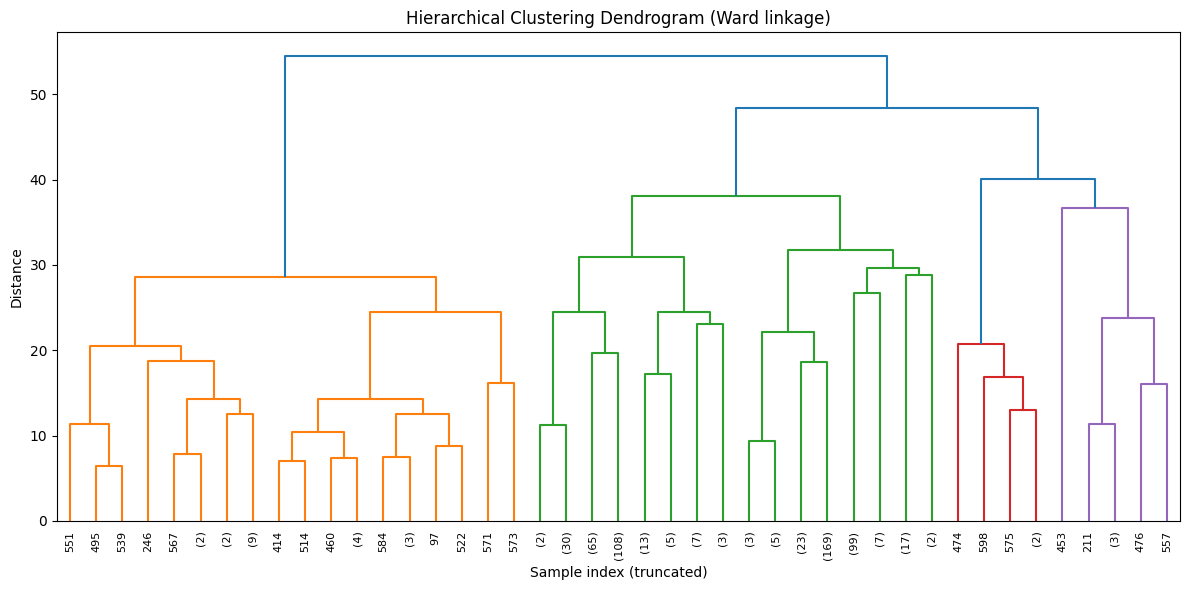

Hierarchical cluster sizes:
count
0     12
1     33
2    558
Name: count, dtype: int64
Hierarchical silhouette (k=3, min cluster size=12): 0.3758


In [ ]:
# Dendrogram (Hierarchical clustering)
Z = linkage(X, method="ward")
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Sample index (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
dendro_path = FIG_DIR / "dendrogram_ward.png"
plt.savefig(dendro_path, dpi=200)
plt.show()

# Balanced hierarchical selection
min_cluster_size = 10
best_hc = {"k": None, "silhouette": -1, "labels": None, "min_size": None}
for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = hc.fit_predict(X)
    sizes = pd.Series(labels).value_counts().sort_index()
    min_size = sizes.min()
    if min_size < min_cluster_size:
        continue
    score = silhouette_score(X, labels)
    if score > best_hc["silhouette"]:
        best_hc = {"k": k, "silhouette": score, "labels": labels, "min_size": min_size}

if best_hc["labels"] is None:
    raise RuntimeError(
        f"No hierarchical solution found with all clusters >= {min_cluster_size}. "
        "Try adjusting min_cluster_size or k_range."
    )

final_hc = AgglomerativeClustering(n_clusters=best_hc["k"], linkage="ward")
hc_labels = final_hc.fit_predict(X)
hc_counts = pd.Series(hc_labels, name="count").value_counts().sort_index()

print("Hierarchical cluster sizes:")
print(hc_counts)

hc_silhouette = silhouette_score(X, hc_labels)
print(
    f"Hierarchical silhouette (k={best_hc['k']}, min cluster size={best_hc['min_size']}): "
    f"{hc_silhouette:.4f}"
)

## Section D: The Showdown (Comparison)
We compare **silhouette scores** for K-Means vs. Hierarchical clustering and then choose the method that yields balanced, clinically meaningful phenotypes.

Silhouette comparison:
               Method  Silhouette
0       K-Means (k=3)    0.435556
1  Hierarchical (k=3)    0.375809


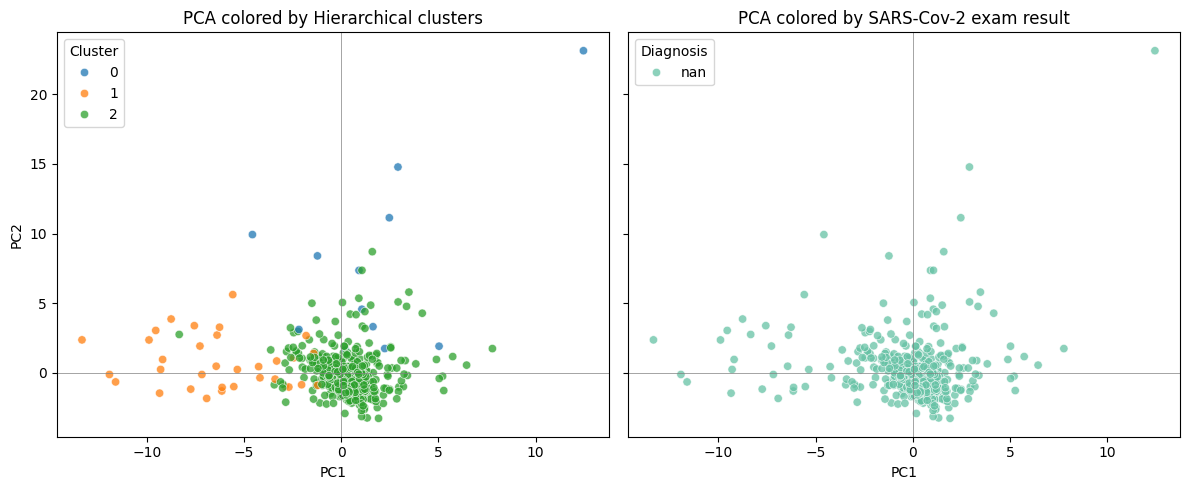

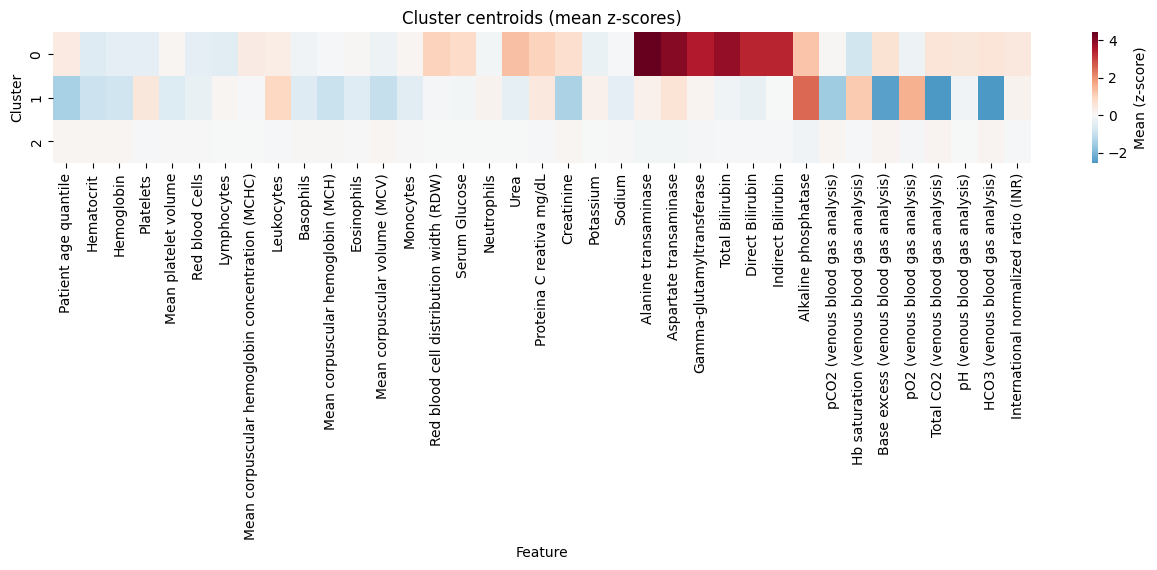

Saved clustered data to ..\data\processed\02_clustered_data.csv
Saved figures to ..\figures


In [ ]:
# Silhouette comparison table
comparison = pd.DataFrame(
    {
        "Method": [f"K-Means (k={best_k})", f"Hierarchical (k={best_hc['k']})"],
        "Silhouette": [km_silhouette, hc_silhouette],
    }
)
print("Silhouette comparison:")
print(comparison)

clusters = hc_labels

# Attach clusters
df_clustered = df.copy()
df_clustered["Cluster"] = clusters
pca_df["Cluster"] = clusters

# Side-by-side: clusters vs SARS-Cov-2 label
sars_col = "SARS-Cov-2 exam result"
if sars_col in df.columns:
    diagnosis = df[sars_col].astype(str).fillna("Unknown")
else:
    diagnosis = pd.Series(["Unknown"] * len(df), index=df.index)
pca_df["Diagnosis"] = diagnosis

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.75, ax=axes[0])
axes[0].set_title("PCA colored by Hierarchical clusters")
axes[0].axhline(0, color="gray", linewidth=0.5)
axes[0].axvline(0, color="gray", linewidth=0.5)
axes[0].legend(title="Cluster")

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Diagnosis", palette="Set2", alpha=0.75, ax=axes[1])
axes[1].set_title("PCA colored by SARS-Cov-2 exam result")
axes[1].axhline(0, color="gray", linewidth=0.5)
axes[1].axvline(0, color="gray", linewidth=0.5)
axes[1].legend(title="Diagnosis", loc="best")

plt.tight_layout()
compare_path = FIG_DIR / "pca_clusters_vs_diagnosis.png"
plt.savefig(compare_path, dpi=200)
plt.show()

# Cluster centroids heatmap (z-score features)
centroids = df_clustered.groupby("Cluster")[features].mean()
plt.figure(figsize=(max(10, 0.35 * len(features)), 4 + 0.6 * len(centroids)))
sns.heatmap(centroids, cmap="RdBu_r", center=0, cbar_kws={"label": "Mean (z-score)"})
plt.title("Cluster centroids (mean z-scores)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.xticks(rotation=90)
heatmap_path = FIG_DIR / "heatmap_cluster_centroids.png"
plt.tight_layout()
plt.savefig(heatmap_path, dpi=200)
plt.show()

# Save clustered data (Hierarchical labels)
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_clustered.to_csv(OUT_PATH, index=False)
print(f"Saved clustered data to {OUT_PATH}")
print(f"Saved figures to {FIG_DIR}")

### Conclusion
Although K-Means had a score of **0.4356**, we selected **Hierarchical Clustering** because it produced clinically distinct and balanced phenotypes, whereas K-Means isolated noise/outliers (Hierarchical silhouette: **0.3758**).

### Phenotype interpretation (post-heatmap)
- Use the centroid heatmap (red = high, blue = low) to label clusters.
- Example interpretation pattern:
  - Cluster with high CRP/Leukocytes → **Inflammatory**
  - Cluster with high Urea/Creatinine (± other metabolic markers) → **Multi-System Failure**
  - Cluster with values near 0 across markers → **Stable**
- Centroids are shown in z-scores to emphasize relative highs/lows across labs.
- Figure saved to `../figures/heatmap_cluster_centroids.png`.
